# Projet 7 : Implémentez un modèle de scoring

# Notebook de la partie modélisation (du prétraitement à la prédiction)

# SALMA CHAFAI

**Mission:**

* Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
    
* L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

* De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

* "Prêt à dépenser" décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

**Résumé de notre mission:**

 * 1- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

 * 2- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

## A) Importation des bibliothèques nécessaires

### 1- Les bibliothèques usuelles et les bibliothèques de visualisation

In [1]:
 # ça nous permet d'importer numpy avec son nom np et matplotlib.pyplot as plt
%pylab inline 

# data
import pandas as pd
import numpy as np
import scipy 

# visualisation
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt

# Librairie plotly pour les graphiques intéractives
import plotly.graph_objects as go
import plotly as plo
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode,iplot
from plotly.subplots import make_subplots

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.stats as stats

### 2- Bibliothèques du ML

In [3]:
# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer


# outliers
from sklearn.ensemble import IsolationForest

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, QuantileTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from category_encoders import TargetEncoder

# Feature engineering
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
import shap #SHAP package
import time #some of the routines take a while so we monitor the time
import os #needed to use Environment Variables in Domino

# Equilibrer les classes
from imblearn.over_sampling import SMOTE

# Modèles
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import kernel_ridge
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Evaluation 
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
from sklearn.model_selection import train_test_split

# pickle est un package qu'on utilise pour mettre dedans ou pour générer notre modèle pour le déployer dans une application
import pickle
import dill

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [4]:
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## B) Jeu de données

In [5]:
# Jeu du données
df = pd.read_csv('C:/Users/salma/OneDrive/Bureau/Projet7/Data/data_clean_vf.csv')
df.drop(columns = 'Unnamed: 0', inplace=True)
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,11559.247,219625.690,9251.775,53093.746,11559.247,219625.690,-49.0,-315.5,-5993.0,19.0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586,1618864.600,6662.970,560835.400,64754.586,1618864.600,-544.0,-1385.0,-34633.0,25.0
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,7096.155,21288.465,5357.250,10573.965,7096.155,21288.465,-727.0,-761.5,-2285.0,3.0
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,62947.090,1007153.440,2482.920,691786.900,62947.090,1007153.440,-12.0,-271.5,-4346.0,16.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,12666.444,835985.300,0.180,22678.785,12214.061,806128.000,-14.0,-1032.0,-68128.0,66.0


In [6]:
#Taille du jeu de données
df.shape

(307507, 624)

In [7]:
((df.isna().sum()/df.shape[0])*100).sort_values(ascending=False)

SK_ID_CURR                             0.0
PREV_CODE_REJECT_REASON_VERIF_MEAN     0.0
PREV_NAME_PAYMENT_TYPE_nan_MEAN        0.0
PREV_CODE_REJECT_REASON_CLIENT_MEAN    0.0
PREV_CODE_REJECT_REASON_HC_MEAN        0.0
                                      ... 
ORGANIZATION_TYPE_Trade: type 7        0.0
ORGANIZATION_TYPE_Transport: type 1    0.0
ORGANIZATION_TYPE_Transport: type 2    0.0
ORGANIZATION_TYPE_Transport: type 3    0.0
INSTAL_COUNT                           0.0
Length: 624, dtype: float64

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
df_reduce = reduce_mem_usage(df)

Memory usage of dataframe is 1463.96 MB
Memory usage after optimization is: 412.91 MB
Decreased by 71.8%


### 1- On prend un échantillon du jeu de données

In [10]:
# On prend un échantillon de 100 clients pour la partie test du dashboard
df_sub = df_reduce.sample(100)
#df_sub.drop(columns='TARGET', inplace=True)
df_sub.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
251952,391533,1,0,0,1,0,225000.0,514777.5,40801.5,477000.0,...,14830.303711,1.646164e+06,185.399994,104771.476562,15082.865234,1.674198e+06,-27.0,-666.00,-73901.0,111.0
91373,206118,0,1,1,0,0,94500.0,495000.0,25402.5,495000.0,...,39179.679688,1.919804e+06,5148.180176,550601.437500,39179.679688,1.919804e+06,-111.0,-859.00,-42095.0,49.0
142079,264739,0,1,1,0,1,202500.0,1125000.0,56250.0,1125000.0,...,12572.687500,3.283601e+05,2314.979980,36000.000000,12226.016602,3.186101e+05,-66.0,-807.50,-21127.0,25.0
211078,344613,0,0,1,0,0,90000.0,495000.0,38434.5,495000.0,...,5273.189941,2.109276e+04,5273.189941,5273.189941,5273.189941,2.109276e+04,-41.0,-85.75,-343.0,4.0
257479,397961,0,1,0,0,0,135000.0,1350000.0,67500.0,1350000.0,...,12572.687500,3.283601e+05,2314.979980,36000.000000,12226.016602,3.186101e+05,-66.0,-807.50,-21127.0,25.0


In [11]:
df_sub.to_csv('echantillon.csv', index=False)

In [12]:
unique(df_sub["TARGET"].values.tolist())

array([0, 1])

## C) Modélisation 

### 1- Séparation du data set en train et test set

In [13]:
deleted_cols = ['TARGET','SK_ID_CURR']

In [14]:
X = df_reduce.drop(columns=deleted_cols)
y = df_reduce['TARGET']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2,
                                                   random_state=42)

In [16]:
y_train.value_counts()

0    226201
1     19804
Name: TARGET, dtype: int64

In [17]:
X.shape

(307507, 622)

In [18]:
y_test.value_counts()

0    56481
1     5021
Name: TARGET, dtype: int64

### 2- Sélection des features

In [19]:
# Le jeu de données "HomeCredit_columns_description"
col_description = pd.read_csv("C:/Users/salma/OneDrive/Bureau/Projet7/Data/Data_kaggle/HomeCredit_columns_description_encode.csv", sep=',', encoding="utf8")

In [20]:
# Create and fit selector
selector = SelectKBest(f_classif, k=20)
selector.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X.iloc[:,cols]

Features [254 259 275 284 363 371 374 400 405 410 420 428 433 448 462 468 472 481
 493 499 517 594] are constant.
invalid value encountered in true_divide


In [21]:
X_new.head()

,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED_PERC,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN
0,-9461,-637.0,2,2,0.083008,0.262939,0.139404,0.067322,1.0,0.0,-1437.0,-874.0,-500.00,0.250,0.750,1.000000,0.000000,0.0,1.000000,0.000000
1,-16765,-1188.0,1,1,0.311279,0.622070,0.535156,0.070862,0.0,1.0,-2586.0,-1401.0,-816.00,0.250,0.750,1.000000,0.000000,0.0,1.000000,0.000000
2,-19046,-225.0,2,2,0.505859,0.556152,0.729492,0.011810,1.0,0.0,-1326.0,-867.0,-532.00,0.000,1.000,1.000000,0.000000,0.0,1.000000,0.000000
3,-19005,-3040.0,2,2,0.505859,0.650391,0.535156,0.159912,1.0,0.0,-1827.0,-1051.0,-481.75,0.375,0.625,0.555664,0.111084,0.0,0.888672,0.000000
4,-19932,-3038.0,2,2,0.505859,0.322754,0.535156,0.152466,1.0,0.0,-1149.0,-1149.0,-783.00,0.000,1.000,1.000000,0.000000,0.0,1.000000,0.166626


In [22]:
features_train = X_new.columns.tolist()
len(features_train)

20

In [23]:
l_description = []
cols_desc = col_description['Row'].tolist()
for feature in features_train : 
    if feature in cols_desc :
        ligne = col_description[col_description['Row'] == feature]['Description'].iloc[0]
        l_description.append(ligne)
    else : 
        l_description.append('Pas de description')

In [24]:
# Enregistrer les colonnes et leurs descriptions
pickle.dump(features_train, open('features_selected.pkl', 'wb'))
pickle.dump(l_description, open('features_description.pkl', 'wb'))

### 3- Modélisation

#### (a) Division du dataset en train et test set

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y, 
                                                    test_size=0.2,
                                                   random_state=42,
                                                   stratify=y)

#### (b) Création de la fonction coût métier

In [26]:
def fct_cout(y_test, y_pred, cout_fp=1, coup_fn=10):
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    resultat = (cout_fp*FP + coup_fn*FN)/(TN + coup_fn*FN + TP + cout_fp*FP)
    return resultat

On transforme la fct_cout en un score en utilisant la fonction make_scorer.

In [27]:
score_cout = make_scorer(fct_cout, greater_is_better=False)

#### (c) Fonctions d'entraînement des modèles

In [28]:
def entrainement_model(model, params,X_train,X_test,y_train, y_test):
    
    """Cette fonction renvoie le meilleur modèle et les meilleurs hyperparamètres
    obtenues par cross validation avec GridSearchCv"""
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    grid_model = GridSearchCV(model, params, cv=5, scoring=score_cout)
    
    t0 = time.time()
    grid_model.fit(X_train,y_train)
    tf = time.time()
    print("Temps d'exécution avec gridSearchCv : {:.4f} seconds".format(tf - t0))
    
        
    

    
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    

    
    return best_model, best_params

#### (d) Fonctions d'évaluation des modèles

In [29]:
def evaluation_model(model, X_train,X_test,y_train, y_test, smote_method = False):
    
    """Cette fonction entraîne le modèle et affiche les scores du modèle"""
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    if smote_method:
        oversampler=SMOTE(random_state=0)
        X_train,y_train=oversampler.fit_resample(X_train,y_train)
    
    t0 = time.time()
    
    model.fit(X_train, y_train)
    tf = time.time()
    print("Temps d'exécution du meilleur modèle : {:.4f} seconds".format(tf - t0))
    
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    roc_train = roc_auc_score(y_train, y_pred_train)
    roc_test = roc_auc_score(y_test, y_pred_test)
    
    beta_score_train = fbeta_score(y_train, y_pred_train, beta=10)
    beta_score_test = fbeta_score(y_test, y_pred_test, beta=10)
    
    
    
    
    print("Accuracy train : ", acc_train)
    print("Accuracy test : ", acc_test)
    print("Roc Accuracy train : ", roc_train)
    print("Roc Accuracy test : ", roc_test)
    print("Beta score train : ", beta_score_train)
    print("Beta score test : ", beta_score_test)
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))
    
    

In [30]:
# Les modèles
model_lr = LogisticRegression(random_state=0, class_weight="balanced")
model_rf = RandomForestClassifier(random_state=0, class_weight="balanced")
model_lgb = LGBMClassifier(random_state=0, class_weight="balanced")
model_xgb = XGBClassifier(random_state=0, class_weight="balanced")

In [31]:
params_lr = {'C': [0.1, 1, 10, 100]}#,'penalty': ['l1', 'l2']} model = LogisticRegression(solver='liblinear')


params_rf = { 
    'n_estimators': [100, 200],#[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_depth' : [2, 5, 10], #[int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split' : [2, 5, 10]
}



params_lgb = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 4, 5]}

params_xgb = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 4, 5]}

#### (a) Pour la régression logistique

In [32]:
best_lr, best_param_lr = entrainement_model(model_lr, params_lr,X_train,X_test,y_train, y_test)
final_model_lr = LogisticRegression(**best_param_lr, random_state=0, class_weight="balanced")
evaluation_model(final_model_lr, X_train,X_test,y_train, y_test)

Temps d'exécution avec gridSearchCv : 35.6011 seconds
Temps d'exécution du meilleur modèle : 2.0741 seconds
Accuracy train :  0.6828316497632162
Accuracy test :  0.6849370752170661
Roc Accuracy train :  0.6715778312834204
Roc Accuracy test :  0.6769715564356691
Beta score train :  0.6376691959211847
Beta score test :  0.646740348572091
[[38811 17726]
 [ 1651  3314]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.16      0.67      0.25      4965

    accuracy                           0.68     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.89      0.68      0.76     61502



#### (b) Pour la forêt aléatoire 

In [33]:
best_rf, best_param_rf = entrainement_model(model_rf, params_rf,X_train,X_test,y_train, y_test)
final_model_rf = RandomForestClassifier(**best_param_rf, random_state=0, class_weight="balanced")
evaluation_model(final_model_rf, X_train,X_test,y_train, y_test)

Temps d'exécution avec gridSearchCv : 3861.5549 seconds
Temps d'exécution du meilleur modèle : 119.6526 seconds
Accuracy train :  0.7357695981788988
Accuracy test :  0.7256674579688466
Roc Accuracy train :  0.717181876865757
Roc Accuracy test :  0.6727610349760527
Beta score train :  0.6771605849768888
Beta score test :  0.594266620793413
[[41603 14934]
 [ 1938  3027]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56537
           1       0.17      0.61      0.26      4965

    accuracy                           0.73     61502
   macro avg       0.56      0.67      0.55     61502
weighted avg       0.89      0.73      0.79     61502



#### (c) Le modèle lightgbm

In [34]:
best_lgb, best_param_lgb = entrainement_model(model_lgb, params_lgb,X_train,X_test,y_train, y_test)
final_model_lgb = LGBMClassifier(**best_param_lgb, random_state=0, class_weight="balanced")
evaluation_model(final_model_lgb, X_train,X_test,y_train, y_test)

Temps d'exécution avec gridSearchCv : 185.6856 seconds
Temps d'exécution du meilleur modèle : 5.6947 seconds
Accuracy train :  0.6920875591959513
Accuracy test :  0.6888719066046632
Roc Accuracy train :  0.6968446084051136
Roc Accuracy test :  0.6823268887127023
Beta score train :  0.6808181691686896
Beta score test :  0.6537880193595275
[[39018 17519]
 [ 1616  3349]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.69      0.76     61502



#### (d) Le modèle XgBoost

In [35]:
best_xgb, best_param_xgb = entrainement_model(model_xgb, params_xgb,X_train,X_test,y_train, y_test)
final_model_xgb = LGBMClassifier(**best_param_xgb, random_state=0, class_weight="balanced", use_label_encoder=False)
evaluation_model(final_model_xgb, X_train,X_test,y_train, y_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:18:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:18:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:19:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:19:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:19:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:19:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:19:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:19:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:19:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:19:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:20:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:20:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:20:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:20:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:21:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:21:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:21:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:21:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:21:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:21:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:22:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:22:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:22:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:22:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:22:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:22:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:23:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:23:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:23:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:23:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:23:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:23:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:24:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:24:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:24:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:24:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:24:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:24:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:24:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:24:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:25:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:25:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:25:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:25:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:25:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:25:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:26:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:26:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:26:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:26:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:26:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:26:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:27:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:27:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:27:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:27:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:28:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:28:02] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:28:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:28:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:28:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:28:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:28:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:28:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:29:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:29:03] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:29:15] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:29:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:29:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:29:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:29:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:29:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:30:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:30:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:30:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:30:21] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:30:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:30:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:30:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:30:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:31:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:31:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:31:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:31:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:32:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:32:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:32:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:32:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[02:32:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:32:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Temps d'exécution avec gridSearchCv : 873.6755 seconds
[LightGBM] [Warning] Unknown parameter: use_label_encoder
Temps d'exécution du meilleur modèle : 5.7044 seconds
Accuracy train :  0.6920875591959513
Accuracy test :  0.688871906604

### 4- Modèle final

On choisit comme modèle final le model LightGBM

#### (a) Définition du seuil de proba pour la fonction coût personnalisée

In [36]:
def pred_seuil(model, X_test, y_test) :
    
    #y_pred = model.predict(X_test)
    
    y_sc = model.predict_proba(X_test)[:,1]
    best_seuil = 0
    best_cost = float('inf')
    
    list_seuils = np.linspace(start=0, stop=1, num=100)

    for seuil in list_seuils:
        y_pred = (y_scores >= seuil).astype(int)
        #print("y pred : ", y_pred)
        total_cost = fct_cout(y_test, y_pred)
        if total_cost < best_cost:
            best_seuil = seuil 
            best_cost = total_cost
            
        
            
    y_pred_f = (y_scores >= best_seuil).astype(int)
    print("prediction : ", y_pred_f)
            
    return best_seuil
    

In [98]:
def affichage_seuil(model, X_test, y_test):
    list_seuils = np.linspace(start=0, stop=1, num=100)
    couts_seuils = []
    
    for seuil in list_seuils :
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= seuil).astype(int)
        couts_seuils.append(fct_cout(y_test, y_pred))
         
    # Plot  
    plt.plot(list_seuils, couts_seuils)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Valeur de la fonction cout")
    
    idx_best = couts_seuils.index(min(couts_seuils))
    meilleure_seuil = list_seuils[idx_best]
    print("meilleure cout : ", meilleure_seuil)
    return meilleure_seuil


In [99]:
def evaluation_model_final(model, X_train, y_train, X_test, y_test):
    
    """Cette fonction donne les scores pour le model final choisi"""
    
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    roc_train = roc_auc_score(y_train, y_pred_train)
    roc_test = roc_auc_score(y_test, y_pred_test)
    
    
    beta_score_train = fbeta_score(y_train, y_pred_train, beta=10)
    beta_score_test = fbeta_score(y_test, y_pred_test, beta=10)
    
    #sc_cout = score_cout(model, y_test, y_pred_test)
    

    
    
    
    
    print("Accuracy train : ", acc_train)
    print("Accuracy test : ", acc_test)
    print("Roc Accuracy train : ", roc_train)
    print("Roc Accuracy test : ", roc_test)
    print("Beta score train : ", beta_score_train)
    print("Beta score test : ", beta_score_test)
    #print("Score de la fonction personnalisée :", sc_cout)
    print(confusion_matrix(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))    
    



#### (b) On met le modèle final dans un Pipeline

In [100]:
model_f = best_lgb

In [101]:
smt = SMOTE(random_state=42)
scaler = StandardScaler()

In [102]:
pipeline = Pipeline([
                     ('scaler', scaler),
                    ('model', model_f)
                          ])

In [103]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced', max_depth=5,
                                random_state=0))])

In [104]:
res = pred_seuil(pipeline, X_test, y_test)
res 

prediction :  [0 0 0 ... 0 0 0]


0.6262626262626263

meilleure cout :  0.6262626262626263


0.6262626262626263

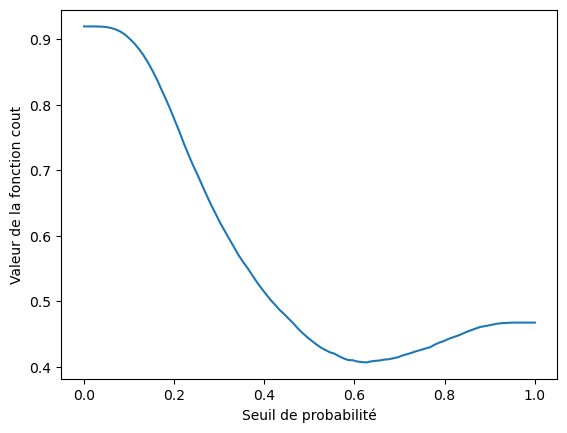

In [105]:
seuil = affichage_seuil(pipeline, X_test, y_test)
seuil

In [80]:
evaluation_model_final(pipeline,X_train, y_train, X_test,y_test)

Accuracy train :  0.6920875591959513
Accuracy test :  0.6888719066046632
Roc Accuracy train :  0.6968446084051136
Roc Accuracy test :  0.6823268887127023
Beta score train :  0.6808181691686896
Beta score test :  0.6537880193595275
[[39018 17519]
 [ 1616  3349]]
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56537
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.68      0.53     61502
weighted avg       0.90      0.69      0.76     61502



In [81]:
# Enregistrer le model logistic regression
#pickle.dump(pipeline_lgb, open('model_credit_rl.pkl', 'wb'))
pickle.dump(pipeline, open('model_credit.pkl', 'wb'))

### 5- Interprétabilité en utilisant shap

#### (a) Interprétabilité globale

In [82]:
pipeline = pickle.load(open("model_credit.pkl","rb"))

In [83]:
# On définit la liste des colonnes
all_features = list(X_new.columns)

In [84]:
# Créer un explicateur SHAP
explainer = shap.TreeExplainer(pipeline.named_steps['model'], X_train)


In [85]:
dill.dump(explainer, open('shap_explainer.dill', 'wb'))

In [86]:
explainer = dill.load(open("shap_explainer.dill","rb"))

In [87]:
# Calculer les valeurs SHAP pour les prédictions de test
shap_values = explainer.shap_values(X_test.values)

 99%|===================| 60887/61502 [03:37<00:02]        

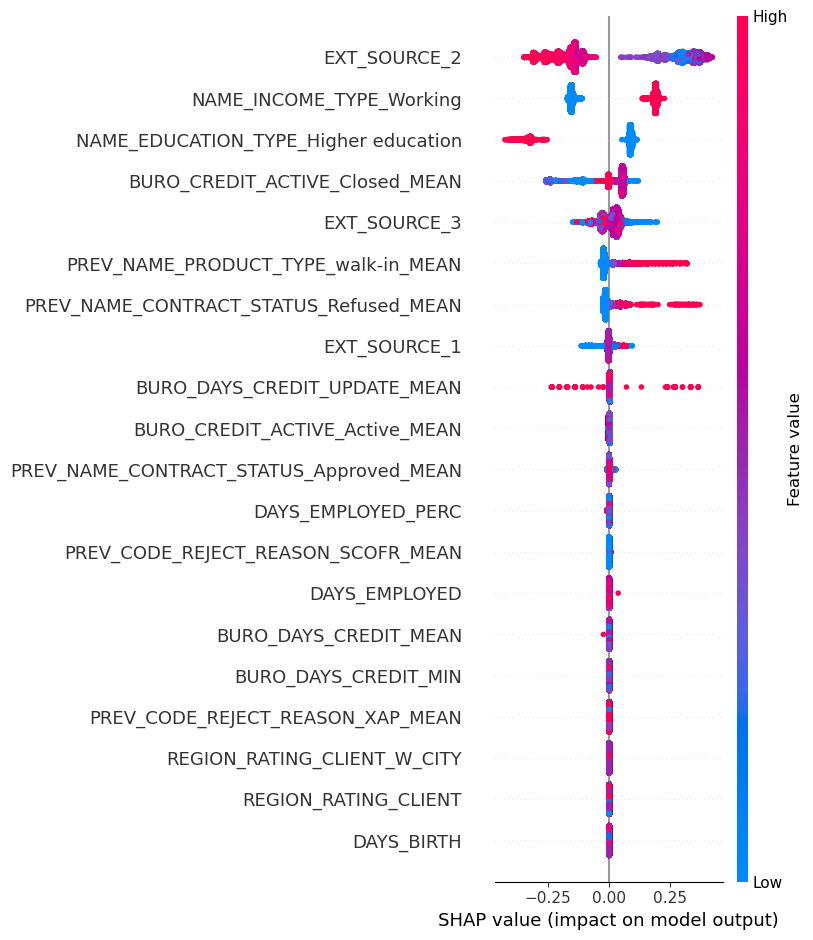

In [88]:
shap.summary_plot(shap_values, X_test, feature_names=all_features)

#### (b) Interprétabilité locale Pour un client 

In [89]:
X_test_sample = df[df["SK_ID_CURR"] == 137021]
X_test_sample

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
31919,137021,0,0,0,0,0,157500.0,117162.0,12433.5,103500.0,...,56395.808594,507562.28125,12659.219727,344867.53125,56395.808594,507562.28125,-596.0,-1573.0,-14160.0,9.0


In [90]:
len(X_test_sample[all_features].columns.tolist())

20

In [91]:
X_test_sample[all_features]

,DAYS_BIRTH,DAYS_EMPLOYED,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_EMPLOYED_PERC,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN
31919,-19434,-3618.0,2,2,0.505859,0.65332,0.209106,0.186157,1.0,1.0,-1889.0,-1059.0,-375.25,0.54541,0.45459,1.0,0.0,0.0,1.0,0.0


In [92]:
shap_values = explainer.shap_values(X_test_sample[all_features])
shap_values[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.01722251e-04, -1.38525572e-01,  4.74158007e-02,  0.00000000e+00,
        1.87978047e-01, -3.40273056e-01,  0.00000000e+00,  0.00000000e+00,
        1.38916228e-03, -1.41523913e-03,  5.46787630e-02, -2.15033200e-04,
       -1.75613737e-02,  0.00000000e+00,  0.00000000e+00, -1.45825372e-02])

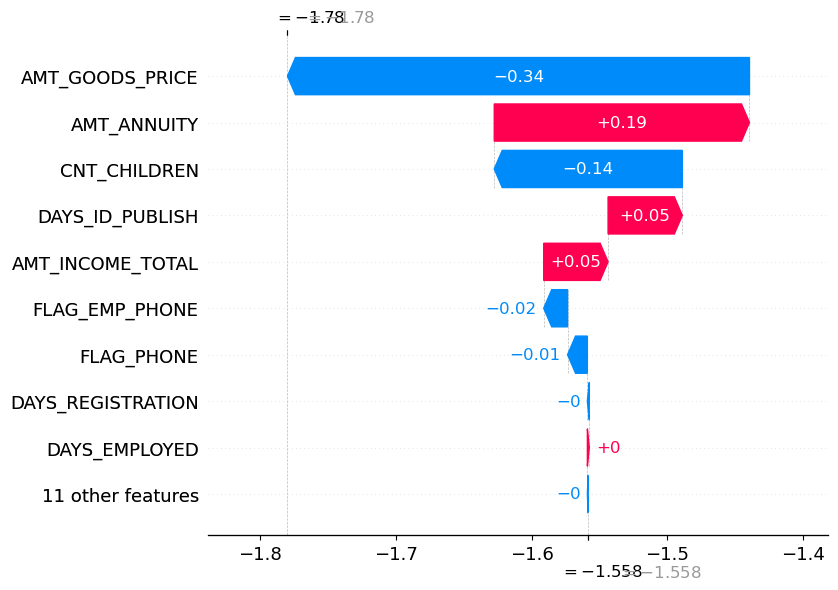

In [93]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,shap_values[0],feature_names = X_test_sample.columns,max_display= 10) 

## D) MlFlow

In [94]:
import mlflow

In [95]:
from mlflow.models.signature import infer_signature

In [96]:
signature = infer_signature(X_train, y_train)

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (trai

In [97]:
mlflow.sklearn.save_model(pipeline, 'mlflow_model', signature=signature)

MlflowException: Path 'mlflow_model' already exists and is not empty